# Прогноз продаж в интернет-магазине

## Описание проекта

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


*Примечание:*

*В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».*


In [3]:
import pandas as pd
import numpy as np
import scipy.stats as st
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def review(df): 
    """создадим функцию для отображения общей информации"""
    info = display(df.head(10)), df.info(), display(df.describe(), df.describe(include=['object', 'bool']))

##  Откроем файл с данными и изучим общую информацию


In [8]:
df = pd.read_csv('/datasets/games.csv')

In [9]:
review(df)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


,Name,Platform,Genre,User_Score,Rating
count,16713,16715,16713,10014,9949
unique,11559,31,12,96,8
top,Need for Speed: Most Wanted,PS2,Action,tbd,E
freq,12,2161,3369,2424,3990


Посмотрим на долю пропущенных значений - если доля менее 1% - данные оставляем без изменения, если же доля превышает 1% - необходимо изучить данные значения.

In [10]:
share = (df.isna().sum() / len(df) * 100).round(2)
share

Name                0.01
Platform            0.00
Year_of_Release     1.61
Genre               0.01
NA_sales            0.00
EU_sales            0.00
JP_sales            0.00
Other_sales         0.00
Critic_Score       51.32
User_Score         40.09
Rating             40.48
dtype: float64

### Вывод

- нарушение стиля в наименованиях столбцов - строчные буквы сочетаются с прописными;
- некорректный тип данных в столбцах `Year_of_Release`, `User_Score`;
- в столбце `User_Score` в топе оценок стоит значение `tbd`;
- доля пропущенных значений менее 1% в столбцах `Name`, `Genre`;
- доля пропущенных значений более 1% в столбцах `Year_of_Release`, `Critic_Score`, `User_Score`, `Rating` в остальных случаях доля пропущенных значений не повлияет на результат исследования

## Подготовим данные для дальнейшего исследования

Приведем наименования столбцов к нижнему регистру

In [11]:
df.columns = [x.lower() for x in df.columns]

Преобразуем типы данных в столбце `year_of_release` - к типу данных `Int64`;

In [12]:
df['year_of_release'] = pd.to_numeric(df['year_of_release']).astype('Int64')

Изучим пропуски в столбце `name`

In [13]:
df[df['name'].isnull()].head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Каких либо полезных данных в этих строках нет, их количество также не повлияет на результат исследования. Удалим их.

In [14]:
df = df.dropna(subset = ['name'])

Изучим пропуски в столбце `year_of_release`

In [15]:
df[df['year_of_release'].isnull()].head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T


Остальные данные строк с пропущенным годом несут могут быть полезны, каких либо закономерностей между данными не обнаружено, а полагаться на год в наименовании некорректно, т.к. год выхода часто отличается.

В столбце `user_score` находятся артефакт в виде абревиатуры `tbd`, вероятно означающий - `подлежит уточнению`. Заменим данные значения на пустые строчки и преобразуем к типу данных `float64`

In [16]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['user_score'] = pd.to_numeric(df['user_score'])

Доля пропусков в столбцах `critic_score`, `user_score` и `rating` слишком большая, посмотрим на данные в этих столбцах. Из документации и общей информации понятно, что оценки критиков были выставлены целыми числами от `0` до `100`, а данные `user_score` с плавующей запятой от `0`, до `10,0`, соответственно в обоих случаях равное количество уникальной оценки. Также из документации и общей информации понятно, что рейтинг определялся по системе [ESRB](https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board), где возможно `7` уникальных значений. Посмотрим на эти данные

In [17]:
df_unique = df[[
    'critic_score',
    'user_score',
    'rating'
]]
for column in df_unique.columns:
    print(df_unique[column].unique())

[76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65. 54.
 20. 53. 37. 38. 33. 52. 30. 32. 43. 45. 51. 40. 46. 39. 34. 35. 41. 36.
 28. 31. 27. 26. 19. 23. 24. 21. 17. 22. 13.]
[8.  nan 8.3 8.5 6.6 8.4 8.6 7.7 6.3 7.4 8.2 9.  7.9 8.1 8.7 7.1 3.4 5.3
 4.8 3.2 8.9 6.4 7.8 7.5 2.6 7.2 9.2 7.  7.3 4.3 7.6 5.7 5.  9.1 6.5 8.8
 6.9 9.4 6.8 6.1 6.7 5.4 4.  4.9 4.5 9.3 6.2 4.2 6.  3.7 4.1 5.8 5.6 5.5
 4.4 4.6 5.9 3.9 3.1 2.9 5.2 3.3 4.7 5.1 3.5 2.5 1.9 3.  2.7 2.2 2.  9.5
 2.1 3.6 2.8 1.8 3.8 0.  1.6 9.6 2.4 1.7 1.1 0.3 1.5 0.7 1.2 2.3 0.5 1.3
 0.2 0.6 1.4 0.9 1.  9.7]
['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


В пропусках столбцов `critic_score` и `user_score` какие либо закономерности в данных и в документации не найти, следует обратиться к операторам по вводу данных.

Пропуски в столбце `rating` заменим на абревиатуру `RP`, что означает - [рейтинг ожидается](https://dic.academic.ru/dic.nsf/ruwiki/140779#:~:text=%C2%ABRP%C2%BB%20(%C2%ABRating%20Pending%C2%BB%22)%C2%A0%E2%80%94%20%C2%AB%D0%A0%D0%B5%D0%B9%D1%82%D0%B8%D0%BD%D0%B3%20%D0%BE%D0%B6%D0%B8%D0%B4%D0%B0%D0%B5%D1%82%D1%81%D1%8F%C2%BB), а значения `K-A` приведем к значению `E`, .т.к. `K-A` является [устаревшим](https://dic.academic.ru/dic.nsf/ruwiki/140779#:~:text=%C2%ABK%2DA%C2%BB%20(%C2%ABKids%20to%20Adults%C2%BB)%E2%80%94%20%C2%AB%D0%94%D0%BB%D1%8F%20%D0%B4%D0%B5%D1%82%D0%B5%D0%B9%20%D0%B8%20%D0%B2%D0%B7%D1%80%D0%BE%D1%81%D0%BB%D1%8B%D1%85%C2%BB) и по сути приравнивается к рейтингу `E`

In [18]:
df.loc[df.loc[:,'rating'].isnull(),'rating'] = 'RP'

In [19]:
df['rating'] = df['rating'].replace('K-A', 'E')

Считаем явные дубликаты.

In [20]:
df.duplicated().sum()

0

Проверим неявные дубликаты. Такие могут встретиться в столбцах `name`, `platform`, `genre` и `rating`, поэтому приведем все значения к нижнему регистру. 

In [21]:
for column in df[['name','platform','genre','rating']]:
    df[column] = df[column].str.lower()

In [22]:
df_unique = df[[
    'name',
    'platform',
    'genre',
    'rating'
]]
for column in df_unique.columns:
    print(df_unique[column].unique())

['wii sports' 'super mario bros.' 'mario kart wii' ...
 'woody woodpecker in crazy castle 5' 'lma manager 2007'
 'haitaka no psychedelica']
['wii' 'nes' 'gb' 'ds' 'x360' 'ps3' 'ps2' 'snes' 'gba' 'ps4' '3ds' 'n64'
 'ps' 'xb' 'pc' '2600' 'psp' 'xone' 'wiiu' 'gc' 'gen' 'dc' 'psv' 'sat'
 'scd' 'ws' 'ng' 'tg16' '3do' 'gg' 'pcfx']
['sports' 'platform' 'racing' 'role-playing' 'puzzle' 'misc' 'shooter'
 'simulation' 'action' 'fighting' 'adventure' 'strategy']
['e' 'rp' 'm' 't' 'e10+' 'ao' 'ec']


Посчитаем суммарные продажи во всех регионах и запишим их в отдельный столбец - `total_sales`

In [23]:
df['total_sales'] = df.apply(lambda row: sum(row[['na_sales','eu_sales','jp_sales','other_sales']]),axis =1)

Проверяем данные.

In [24]:
review(df)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,e,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,rp,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,e,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,e,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,rp,31.38
5,tetris,gb,1989,puzzle,23.20,2.26,4.22,0.58,NaN,NaN,rp,30.26
6,new super mario bros.,ds,2006,platform,11.28,9.14,6.50,2.88,89.0,8.5,e,29.80
7,wii play,wii,2006,misc,13.96,9.18,2.93,2.84,58.0,6.6,e,28.91
8,new super mario bros. wii,wii,2009,platform,14.44,6.94,4.70,2.24,87.0,8.4,e,28.32
9,duck hunt,nes,1984,shooter,26.93,0.63,0.28,0.47,NaN,NaN,rp,28.31


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null Int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             16713 non-null object
total_sales        16713 non-null float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.7+ MB


,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,16444.000000,16713.000000,16713.000000,16713.000000,16713.000000,8137.000000,7590.000000,16713.000000
mean,2006.486256,0.263302,0.145045,0.077625,0.047343,68.967679,7.125046,0.533315
std,5.875525,0.813565,0.503359,0.308871,0.186742,13.938165,1.500006,1.548282
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000,0.470000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000,82.540000


,name,platform,genre,rating
count,16713,16713,16713,16713
unique,11559,31,12,7
top,need for speed: most wanted,ps2,action,rp
freq,12,2161,3369,6767


### Вывод

- наименования столбцов приведены к нижнему регистру;
- тип данных в столбце `Year_of_Release` приведен к `datetime`;
- в столбце `User_Score` значения `tbd` изменено на пустые значения;
- тип данных столбца `User_Score` приведен к `float64`;
- в пропусках столбцов `critic_score` и `user_score` какие либо закономерности в данных и в документации не найти, следует обратиться к операторам по вводу данных;
- пропуски в столбце `rating` заменены на абревиатуру `RP`, что означает - [рейтинг ожидается](https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board#:~:text=%C2%ABRP%C2%BB%20(%C2%ABRating%20Pending%C2%BB)%20%E2%80%94%20%C2%AB%D0%A0%D0%B5%D0%B9%D1%82%D0%B8%D0%BD%D0%B3%20%D0%BE%D0%B6%D0%B8%D0%B4%D0%B0%D0%B5%D1%82%D1%81%D1%8F%C2%BB);
- значения `K-A` приведены к значению `E`, .т.к. `K-A` является [устаревшим](https://dic.academic.ru/dic.nsf/ruwiki/140779#:~:text=%C2%ABK%2DA%C2%BB%20(%C2%ABKids%20to%20Adults%C2%BB)%E2%80%94%20%C2%AB%D0%94%D0%BB%D1%8F%20%D0%B4%D0%B5%D1%82%D0%B5%D0%B9%20%D0%B8%20%D0%B2%D0%B7%D1%80%D0%BE%D1%81%D0%BB%D1%8B%D1%85%C2%BB) и по сути приравнивается к рейтингу `E`;
- данных в столбцах `name`, `platform`, `genre` и `rating` приведены к нижнему регистру;
- добавлен столбец `total_sales` с суммами продажи во всех регионах.

## Проведем исследовательский анализ данных

### Посмотрим, сколько игр выпускалось в разные годы. 

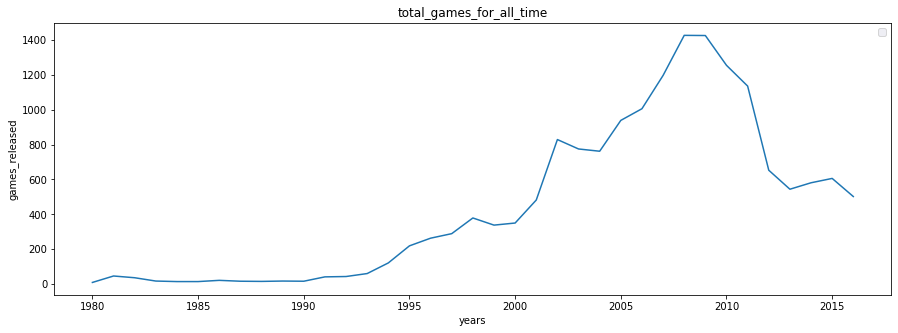

In [25]:
total_games_for_all_time = df.pivot_table(index='year_of_release', 
                                          values='name', 
                                          aggfunc='count')
plt.figure(figsize=(15,5))
sns.lineplot(data=total_games_for_all_time)
sns.set_style('darkgrid')
plt.title("total_games_for_all_time")
plt.xlabel("years")
plt.ylabel("games_released")
plt.legend('')
plt.show()

#### Вывод

- больше всего игр было выпущено в период с ~2002 по ~2012 годы; 
- данные до ~2002 года не повлияют на исследование.

### Посмотрим, как менялись продажи по платформам. 

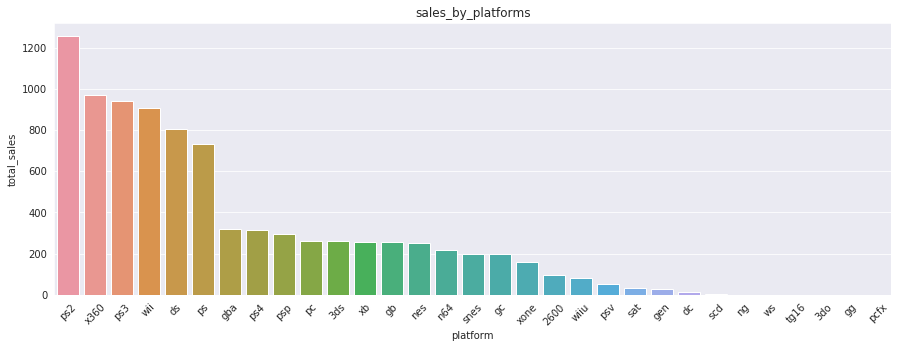

In [26]:
sales_by_platforms = df.pivot_table(index='platform', 
                                   values='total_sales', 
                                   aggfunc='sum').sort_values(by='total_sales', 
                                                              ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(x=sales_by_platforms.index,
            y=sales_by_platforms['total_sales'])
sns.set_style('darkgrid')
plt.title("sales_by_platforms")
plt.xlabel("platform")
plt.ylabel("total_sales")
plt.xticks(rotation=45)
plt.show()

Выберем **ТОП-10** платформ с наибольшими суммарными продажами и построим распределение по годам.

In [27]:
top10_platforms = df.groupby('platform').agg({'total_sales':'sum'}).sort_values(by = 'total_sales', 
                                                                                ascending = False)[:10].index

In [28]:
life_platforms = df.pivot_table(index=['platform','year_of_release'], values = 'total_sales', aggfunc = 'sum')

In [29]:
life_platforms['years'] =  life_platforms.index
life_platforms['years'] = life_platforms['years'].apply (lambda row: row[1]).astype('int')

Визуализируем данные

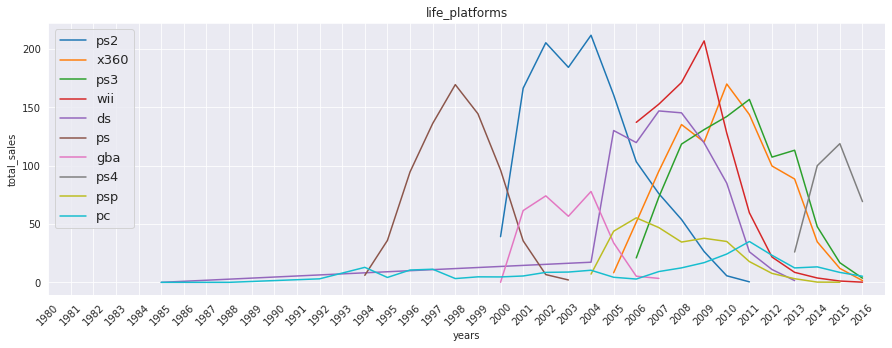

In [30]:
fig, ax = plt.subplots(figsize =(15,5))
for platform in top10_platforms:
    life_platforms.loc[platform].plot('years',
                                     'total_sales',
                                      ax=ax,
                                      rot=45,
                                      grid=True
                                     )
ax.legend(top10_platforms,prop = {'size':13})
ax.set_xlim([1980,2017])
ax.set_xticks(np.arange(1980,2017))
ax.set_xticklabels(range(1980,2017))
plt.title("life_platforms")
plt.xlabel("years")
plt.ylabel("total_sales")
plt.show()

#### Вывод

По данным ТОП-10 наиболее прибыльных платформ:
- период с 1985 по 2000 годы - три платформы, две из которых проявляют активность;
- период с 2000 по 2004 годы - две платформы, активность платформ 7 и 11 лет;
- период с 2004 по 2013 годы - четыре платформы, наиболее насыщенный период по количеству вышедших платформ;
- период с 2013 года - одна платформа.

### Посмотрим на платформы за соответсвующий актуальный период

Наиболее насыщенный период - с 2004 по 2013 годы, следовательно можно считать, что `актуальный период` игровых платформ это `10` лет. Однако, для планирования рекламных компаний данный период слишком велик, поэтому возьмем примем актуальный период в `5` лет. Посмотрим на данные за последний `актуальный период`


In [31]:
period = (2011, 2016)
actual_period = df.query('@period[0] <= year_of_release <= @period[1]') 

In [32]:
review(actual_period)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,grand theft auto v,ps3,2013,action,7.02,9.09,0.98,3.96,97.0,8.2,m,21.05
23,grand theft auto v,x360,2013,action,9.66,5.14,0.06,1.41,97.0,8.1,m,16.27
29,call of duty: modern warfare 3,x360,2011,shooter,9.04,4.24,0.13,1.32,88.0,3.4,m,14.73
31,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,rp,14.63
33,pokemon x/pokemon y,3ds,2013,role-playing,5.28,4.19,4.35,0.78,NaN,NaN,rp,14.60
34,call of duty: black ops ii,ps3,2012,shooter,4.99,5.73,0.65,2.42,83.0,5.3,m,13.79
35,call of duty: black ops ii,x360,2012,shooter,8.25,4.24,0.07,1.12,83.0,4.8,m,13.68
37,call of duty: modern warfare 3,ps3,2011,shooter,5.54,5.73,0.49,1.57,88.0,3.2,m,13.33
40,mario kart 7,3ds,2011,racing,5.03,4.02,2.69,0.91,85.0,8.2,e,12.65
42,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,m,12.62


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4022 entries, 16 to 16714
Data columns (total 12 columns):
name               4022 non-null object
platform           4022 non-null object
year_of_release    4022 non-null Int64
genre              4022 non-null object
na_sales           4022 non-null float64
eu_sales           4022 non-null float64
jp_sales           4022 non-null float64
other_sales        4022 non-null float64
critic_score       1812 non-null float64
user_score         2032 non-null float64
rating             4022 non-null object
total_sales        4022 non-null float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 412.4+ KB


,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,4022.000000,4022.000000,4022.000000,4022.000000,4022.000000,1812.000000,2032.000000,4022.000000
mean,2013.092989,0.206305,0.166532,0.061077,0.051942,71.274283,6.633022,0.485855
std,1.776160,0.570441,0.482864,0.220248,0.155342,13.095847,1.541293,1.219503
min,2011.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.200000,0.010000
25%,2011.000000,0.000000,0.000000,0.000000,0.000000,64.000000,5.800000,0.040000
50%,2013.000000,0.040000,0.030000,0.000000,0.010000,74.000000,7.000000,0.130000
75%,2015.000000,0.170000,0.130000,0.050000,0.040000,81.000000,7.800000,0.407500
max,2016.000000,9.660000,9.090000,4.390000,3.960000,97.000000,9.300000,21.050000


,name,platform,genre,rating
count,4022,4022,4022,4022
unique,2418,12,12,6
top,fifa 14,ps3,action,rp
freq,9,708,1269,1709


In [33]:
actual_period_pivot_table = actual_period.pivot_table(index = ['year_of_release','platform'], 
                                                    values = 'total_sales',
                                                    aggfunc = 'sum')

In [34]:
pivot_table_index = actual_period_pivot_table.index.to_list()

In [35]:
actual_period_pivot_table["years"] = [year for year, platform in pivot_table_index]

In [36]:
actual_period_pivot_table.index = [platform for year, platform in pivot_table_index]

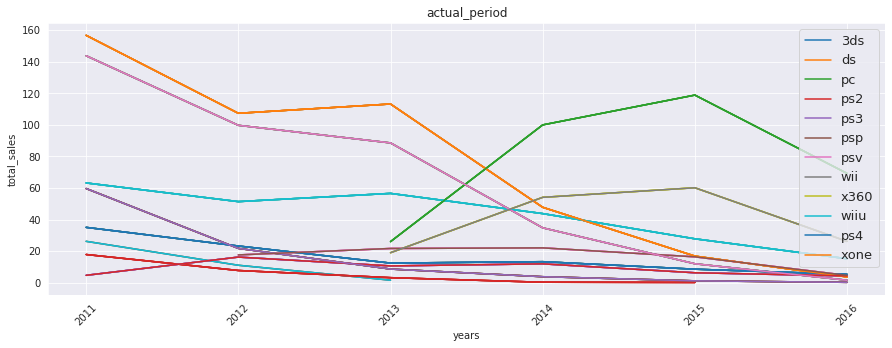

In [37]:
fig, ax = plt.subplots(figsize =(15,5))
for platform in actual_period_pivot_table.index:
    ax.plot(actual_period_pivot_table.loc[platform]['years'],
            actual_period_pivot_table.loc[platform]['total_sales']
           )
ax.legend(actual_period_pivot_table.index.unique(),prop = {'size':13})
plt.title("actual_period")
plt.xlabel("years")
plt.ylabel("total_sales")
plt.xticks(rotation=45)
plt.show()

По графику видно, что за `актуальный период` продажи на всех вышедших платформах падают.

Посмотрим на общую прибыль данных платформ.

In [38]:
top_selling_platforms = actual_period.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(
    by='total_sales', ascending=False).head()
top_selling_platforms = top_selling_platforms.reset_index().rename_axis(None, axis=1)
top_selling_platforms

,platform,total_sales
0,ps3,445.57
1,x360,380.38
2,ps4,314.14
3,3ds,257.81
4,xone,159.32


#### Вывод

- `актуальный период` игровых платформ - `5` лет;
- все вышедшие игровые платформы на последний `актуальный период` падают по продажам;
- потенциально прибыльные платформы - это `ps3`, `x360`, `ps4`, `3ds`, `xone`

### Посмотрим на глобальные продажи игр за последний `актуальный период`  в разбивке по игровым платформам

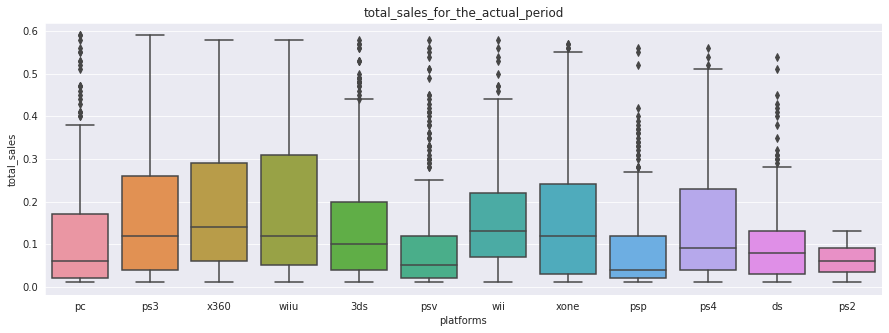

In [39]:
top_quantile = df['total_sales'].quantile(0.75)
low_quantile = df['total_sales'].quantile(0.25)
threshold = top_quantile + 2*low_quantile
fig, ax = plt.subplots(figsize =(15,5))
sns.boxplot(x = 'platform', 
            y = 'total_sales',
            data = actual_period.query('total_sales <= @threshold'),ax=ax)  
sns.set_style('darkgrid')
plt.title('total_sales_for_the_actual_period')
plt.xlabel('platforms')
plt.ylabel('total_sales')
plt.show()

#### Вывод

- медиана у всех вышедших платформ за последний `актуальный период` проходит по разному;
- у большинства платформ, вышедших за последний `актуальный период` наблюдаются выбросы - данные выбросы не влияют на медиану;
- выделяются платформы с медианой выше `0.1` млн - `ps3`, `x360`,  `ps3`, `wiiu`, `wii`, `xone`;
- наиболее равномерное распредление у платформ `xone`, `ds` и `ps2`.

### Посмотрим, как влияют на продажи отзывы пользователей и критиков.

Наиболее равномерное распределение с наибольшей медианой у платформы `xone` - проведем по ней исследование.

In [40]:
xone_critic_score = actual_period.query('platform == "xone"')['critic_score']
xone_user_score = actual_period.query('platform == "xone"')['user_score']
xone_total_sales = actual_period.query('platform == "xone"')['total_sales']

In [41]:
print('Коэффициент корреляции Пирсона (отзывы критиков) равен', xone_critic_score.corr(xone_total_sales).round(2)) 
print('Коэффициент корреляции Пирсона (отзывы пользователей) равен', xone_user_score.corr(xone_total_sales).round(2))

Коэффициент корреляции Пирсона (отзывы критиков) равен 0.42
Коэффициент корреляции Пирсона (отзывы пользователей) равен -0.07


Визуализируем данные

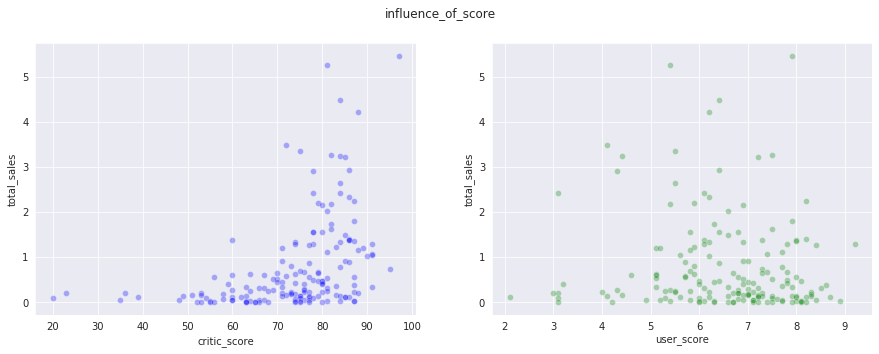

In [42]:
fig, ax = plt.subplots(1 ,2, figsize=(15,5))
sns.scatterplot(x='critic_score', 
                y='total_sales',
                alpha=0.3, 
                color = 'b',
                ax=ax[0],
                data=actual_period.query('platform == "xone"').dropna()
               )
sns.scatterplot(x='user_score',
                y='total_sales',
                alpha=0.3,
                color = 'g',
                ax=ax[1],
                data=actual_period.query('platform == "xone"').dropna()
               )
sns.set_style('darkgrid')
fig.suptitle('influence_of_score')
ax[0].set(xlabel='critic_score')
ax[1].set(xlabel='user_score')
ax[0].set(ylabel='total_sales')
ax[1].set(ylabel='total_sales')
plt.show()

#### Вывод

- зависимости продаж `total_sales` от отзывов критиков `critic_score` отображена на графике - корреляция слабая положительная. Коэфициент коррелиции Пирсона равен `0.42`;
- зависимость продаж `total_sales` от отзывов пользователей `user_score` нет, это подтверждает график и коэфициент корреляции Пирсона, который равен `-0.07`;

Можно сделать вывод, что оценки критиков оказывают влияние на продажи. Также следует учитывать, что в столбцах `critic_score`  `user_score` имеются большое количество пропущенных значений.

#### Соотнесем выводы с продажами игр на других платформах.

In [43]:
all_platform_critic_score = actual_period.query('platform != "xone"')['critic_score']
all_platform_user_score = actual_period.query('platform != "xone"')['user_score']
all_platform_total_sales = actual_period.query('platform != "xone"')['total_sales'] 

In [44]:
print('Коэффициент корреляции Пирсона (отзывы критиков) равен', all_platform_critic_score.corr(all_platform_total_sales).round(2))
print('Коэффициент корреляции Пирсона (отзывы пользователей) равен', all_platform_user_score.corr(all_platform_total_sales).round(2))

Коэффициент корреляции Пирсона (отзывы критиков) равен 0.33
Коэффициент корреляции Пирсона (отзывы пользователей) равен 0.04


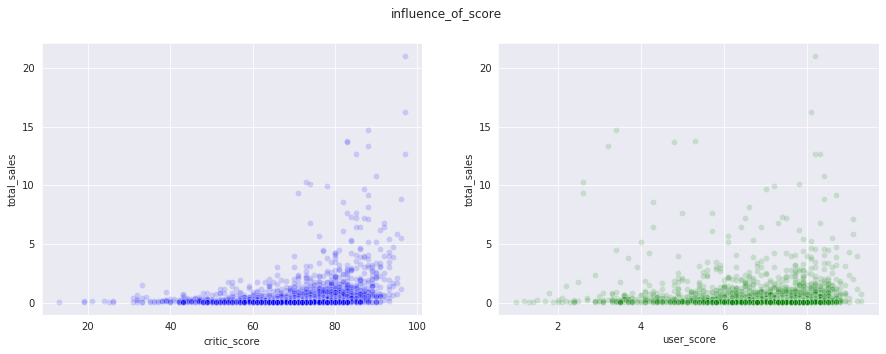

In [45]:
fig, ax = plt.subplots(1 ,2, figsize=(15,5))
sns.scatterplot(x='critic_score', 
                y='total_sales',  
                alpha=0.15,
                color = 'b',
                ax=ax[0],
                data=actual_period.query('platform != "xone"').dropna()
               )
sns.scatterplot(x='user_score', 
                y='total_sales', 
                alpha=0.15, 
                color = 'g',
                ax=ax[1],
                data=actual_period.query('platform != "xone"').dropna() 
               )
sns.set_style('darkgrid')
fig.suptitle('influence_of_score')
ax[0].set(xlabel='critic_score')
ax[1].set(xlabel='user_score')
ax[0].set(ylabel='total_sales')
ax[1].set(ylabel='total_sales')
plt.show()

#### Вывод

- зависимости продаж `total_sales` от отзывов критиков `critic_score` очень низкая - корреляция слабая положительная. Коэфициент коррелиции Пирсона равен `0.33`;
- зависимость продаж `total_sales` от отзывов пользователей `user_score` нет, это подтверждает график и коэфициент корреляции Пирсона, который равен `0.04`;

О какой либо зависимости сказать сложно, т.к. имеются большое количество пропущенных значений, что приводит к низким показателям корреляции Пирсона.

### Посмотрим на общее распределение игр по жанрам.

Смотреть будем на среднюю и медиану всех продаж, т.к. за высокими показателями общих продаж может скрываться множество мелких игр с низкими продажами.

In [46]:
by_genre = actual_period.pivot_table(index='genre', values='total_sales', aggfunc='mean').sort_values(
    by='total_sales', ascending=False).reset_index().rename_axis(None, axis=1)
by_genre

,genre,total_sales
0,shooter,1.224650
1,platform,0.726885
2,sports,0.609640
3,role-playing,0.528237
4,racing,0.490611
5,action,0.439559
6,fighting,0.420755
7,misc,0.371787
8,simulation,0.369559
9,strategy,0.189402


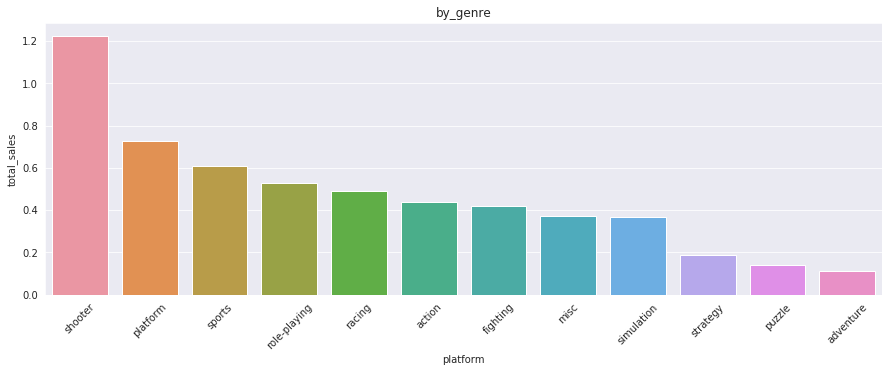

In [47]:
plt.figure(figsize=(15,5))
sns.barplot(x=by_genre['genre'],
            y=by_genre['total_sales'])
sns.set_style('darkgrid')
plt.title("by_genre")
plt.xlabel("platform")
plt.ylabel("total_sales")
plt.xticks(rotation=45)
plt.show()

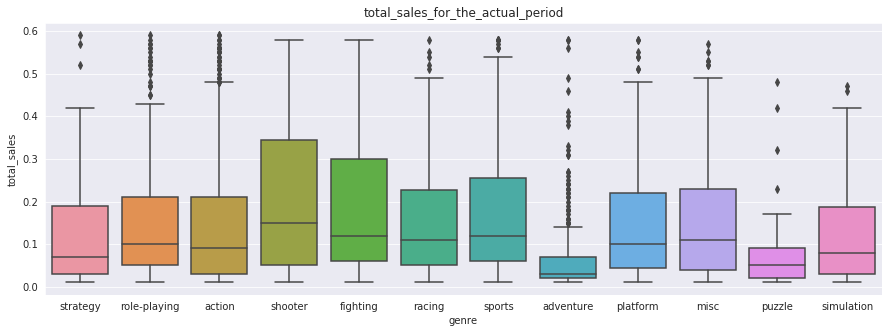

In [48]:
top_quantile = df['total_sales'].quantile(0.75)
low_quantile = df['total_sales'].quantile(0.25)
threshold = top_quantile + 2*low_quantile
fig, ax = plt.subplots(figsize =(15,5))
sns.boxplot(x = 'genre', 
            y = 'total_sales',
            data = actual_period.query('total_sales <= @threshold'),ax=ax)  
sns.set_style('darkgrid')
plt.title('total_sales_for_the_actual_period')
plt.xlabel('genre')
plt.ylabel('total_sales')
plt.show()

#### Вывод

- наиболее продаваемые жанры игр, за последний актулальный период - это `shooter`, `sports`, `platform`, `role-playing`, `racing`, `action`, `fighting`, `misc`, `simulation`;
- наименее продаваемые жанры игр за последний актулальный период - это `strategy`, `puzzle`, `adventure`.

## Составим портрет пользователя каждого региона.

In [49]:
by_platform_all_region = actual_period.pivot_table(index = 'platform', 
                                               values = ['na_sales','jp_sales','eu_sales'], 
                                               aggfunc = ['sum'])
by_platform_all_region.columns = ['na_sales','jp_sales','eu_sales']

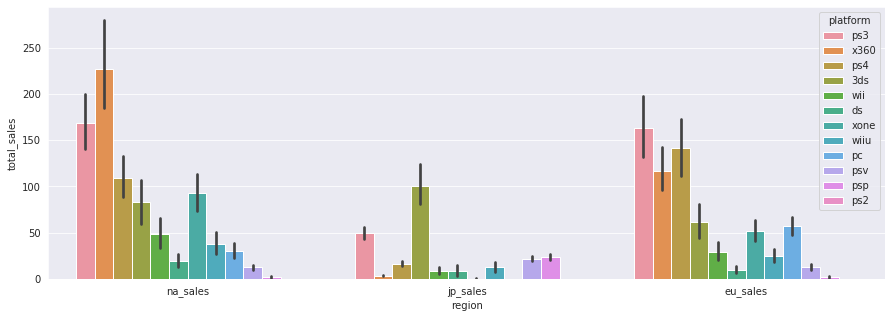

In [50]:
by_platform_all_reg = actual_period.melt(id_vars=['platform'], value_vars=['na_sales','jp_sales','eu_sales'])
by_platform_all_reg.columns = ['platform', 'region', 'total_sales']
plt.figure(figsize =(15,5))
sns.barplot(data=by_platform_all_reg, x='region', y='total_sales', hue='platform', estimator=sum)
plt.xlabel('region')
plt.ylabel('total_sales')
plt.show()

Во всех странах популярны консольные платформы, отдельно выделяется - `ps3`

### Северная Америка

#### Самые популярные платформы - `ТОП-5`

Выберем `ТОП-5` платформ по региону `Серерная Америка` и посчитаем их долю продаж.

In [51]:
top5_na = by_platform_all_region.sort_values(by = 'na_sales', ascending = False).index[:5]

In [52]:
list_of_top = [top5_na]
for count,top in enumerate(list_of_top):
    if count == 0: 
        print('Топ-5 платформ для региона Северная Америка:',*top)
    print()
    for platform in top:
        data = by_platform_all_region.loc[platform,['na_sales','jp_sales','eu_sales']]
        if count == 0: 
            part = data['na_sales']
        ratio = ((part / sum(data))*100).round(2)
        print('Доля продаж платформы', platform ,ratio)
        print()

Топ-5 платформ для региона Северная Америка: ps3 ps4 x360 3ds pc

Доля продаж платформы ps3 42.84

Доля продаж платформы ps4 53.08

Доля продаж платформы x360 33.72

Доля продаж платформы 3ds 25.06

Доля продаж платформы pc 65.49



#### Самые популярные жанры  - `ТОП-5`

,na_sales
genre,
action,230.92
shooter,194.43
sports,108.70
role-playing,83.78
misc,69.69


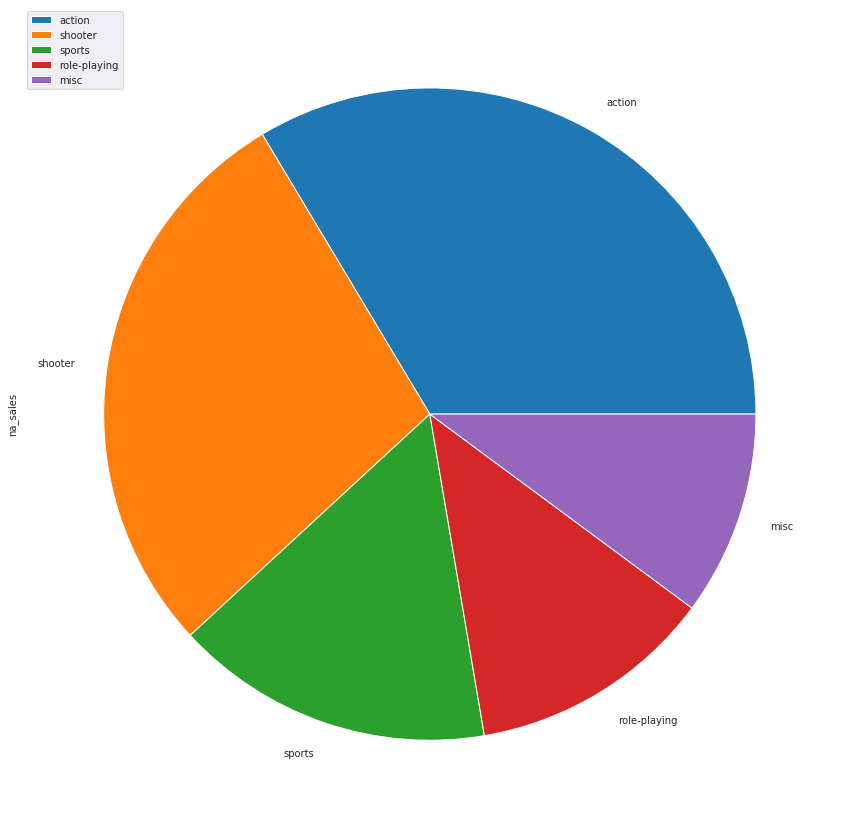

In [53]:
by_genre_na_sales = actual_period.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(
    by='na_sales', ascending=False).head()
display(by_genre_na_sales)
by_genre_na_sales.plot(y= 'na_sales', kind = 'pie', figsize =(15,15))
plt.show()

#### Влияние рейтинга `ESRB` на продажи в регионе

In [54]:
actual_period.pivot_table(index = 'rating', 
                    values = ['na_sales'], 
                    aggfunc = ['mean']
                         ).round(2).T

,rating,e,e10+,ec,m,rp,t
mean,na_sales,0.28,0.26,0.42,0.5,0.07,0.18


#### Вывод

- топ-5* платформ - `pc`, `ps4`, `ps3`, `x360`, `3ds`.;
- топ-5* жанров - `action`, `shooter`, `sports`, `role-playing`, `misc`.;
- наиболее продаваемые игры с рейтингом `m` - для взрослых.


**от большего к меньшему*

### Япония

#### Самые популярные платформы - `ТОП-5`

Выберем `ТОП-5` платформ по региону `Япония` и посчитаем их долю продаж.

In [55]:
top5_jp = by_platform_all_region.sort_values(by = 'jp_sales', ascending = False).index[:5]

In [56]:
list_of_top = [top5_jp]
for count,top in enumerate(list_of_top):
    if count == 0: 
        print('Топ-5 платформ для региона Япония:',*top)
    print()
    for platform in top:
        data = by_platform_all_region.loc[platform,['na_sales','jp_sales','eu_sales']]
        if count == 0: 
            part = data['jp_sales']
        ratio = ((part / sum(data))*100).round(2)
        print('Доля продаж платформы', platform, ratio)
        print()

Топ-5 платформ для региона Япония: 3ds ps3 psp psv ps4

Доля продаж платформы 3ds 41.15

Доля продаж платформы ps3 12.97

Доля продаж платформы psp 85.86

Доля продаж платформы psv 46.1

Доля продаж платформы ps4 6.0



#### Самые популярные жанры  - `ТОП-5`

,jp_sales
genre,
role-playing,79.87
action,63.62
misc,17.60
fighting,12.38
platform,12.13


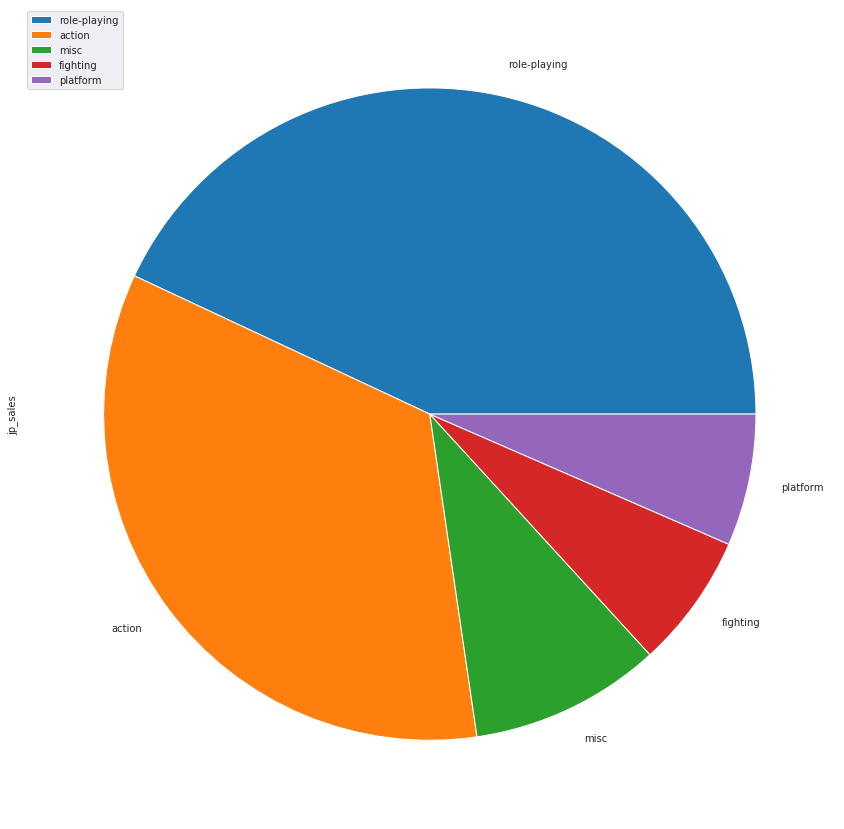

In [57]:
by_genre_jp_sales = actual_period.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(
    by='jp_sales', ascending=False).head()
by_genre_jp_sales
display(by_genre_jp_sales)
by_genre_jp_sales.plot(y= 'jp_sales', kind = 'pie', figsize =(15,15))
plt.show()

#### Влияние рейтинга `ESRB` на продажи в регионе

In [58]:
actual_period.pivot_table(index = 'rating', 
                    values = ['jp_sales'], 
                    aggfunc = ['mean']
                         ).round(2).T

,rating,e,e10+,ec,m,rp,t
mean,jp_sales,0.06,0.02,0.0,0.04,0.08,0.05


#### Вывод

- топ-5* платформ - `3ds`, `ps3`, `psp`, `psv`, `ps4`;
- топ-5* жанров - `role-playing`, `action`, `misc`, `fighting`, `platform`;
- наиболее продаваемые игры с рейтингом `rp` - рейтинг ожидается.

**от большего к меньшему*

### Европа

#### Самые популярные платформы - `ТОП-5`

Выберем `ТОП-5` платформ по региону `Европа` и посчитаем их долю продаж.

In [59]:
top5_eu = by_platform_all_region.sort_values(by = 'eu_sales', ascending = False).index[:5]

In [60]:
list_of_top = [top5_eu]
for count,top in enumerate(list_of_top):
    if count == 0: 
        print('Топ-5 платформ для региона Европа:',*top)
    print()
    for platform in top:
        data = by_platform_all_region.loc[platform,['na_sales','jp_sales','eu_sales']]
        if count == 0: 
            part = data['eu_sales']
        ratio = ((part / sum(data))*100).round(2)
        print('Доля продаж платформы', platform ,ratio)
        print()

Топ-5 платформ для региона Европа: x360 ps3 ps4 xone 3ds

Доля продаж платформы x360 65.31

Доля продаж платформы ps3 44.19

Доля продаж платформы ps4 40.91

Доля продаж платформы xone 64.2

Доля продаж платформы 3ds 33.8



#### Самые популярные жанры  - `ТОП-5`

,eu_sales
genre,
action,199.12
shooter,148.02
sports,88.48
role-playing,62.30
racing,40.58


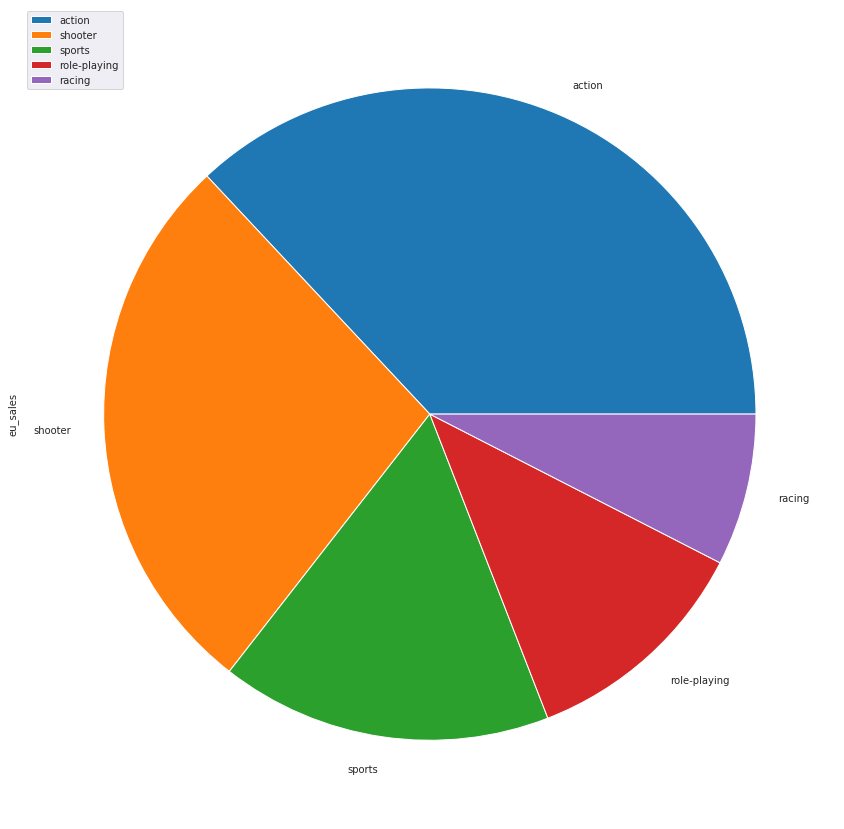

In [61]:
by_genre_eu_sales = actual_period.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(
    by='eu_sales', ascending=False).head()
display(by_genre_eu_sales)
by_genre_eu_sales.plot(y= 'eu_sales', kind = 'pie', figsize =(15,15))
plt.show()

#### Влияние рейтинга `ESRB` на продажи в регионе

In [62]:
actual_period.pivot_table(index = 'rating', 
                    values = ['eu_sales'], 
                    aggfunc = ['mean']
                         ).round(2).T

,rating,e,e10+,ec,m,rp,t
mean,eu_sales,0.23,0.17,0.0,0.4,0.07,0.14


#### Вывод

- топ-5* платформ - `x360`, `xone`, `ps3`, `ps4`, `3ds`.
- топ-5* жанров - `action`, `shooter`, `sports`, `role-playing`, `racing`.
- наиболее продаваемые игры с рейтингом `m` - для взрослых.

**от большего к меньшему*

### Вывод по портрету пользователя по всем регионам.

- Пользователи по региону `Серерная Америка` выбирают консольные игры на платформах `ps3`, `x360`, `wii`, `ds`, `ps4` в жанре `action`, `sports`, `shooter`, `misc`, `role-playing`;
- возврастной рейтинг безусловно влияет на продажи, так по региону наиболее популярны игры с рейтингом `m` - для взрозслых.

- Пользователи по региону `Япония` выбирают консольные игры на платформах `ds`, `3ds`, `ps3`, `psp`, `wii` в жанре `action`, `sports`, `shooter`, `misc`, `role-playing`;
- возврастной рейтинг безусловно влияет на продажи, так по региону наиболее популярные игры с рейтингом `e` - для всех и `t` - подросткам.

- Пользователи по региону `Европа` выбирают консольные игры на платформах `ps3`, `x360`, `wii`, `ds`, `ps4` в жанре `action`, `sports`, `shooter`, `misc`, `role-playing`;
- возврастной рейтинг безусловно влияет на продажи, так по региону наиболее популярны игры с рейтингом `m` для взрозслых.

## Проверим гипотезы

### Гипотеза №1

- средние пользовательские рейтинги платформ `xone` и `pc` одинаковые;

Следовательно:

**Нулевая гипотеза:** средние пользовательские рейтинги платформы `xone` и `pc` равны.

**Альтернативная гипотеза:** средние пользовательские рейтинги платформы `xone` и `pc` отличаются.

In [63]:
np.var(actual_period[actual_period['platform']=='xone']['user_score'])

1.8965188383045526

In [64]:
np.var(actual_period[actual_period['platform']=='pc']['user_score'])

2.5878388099608487

In [65]:
alpha = 0.05

result_first = st.ttest_ind(actual_period[actual_period['platform']=='xone']['user_score'].dropna(),
                            actual_period[actual_period['platform']=='pc']['user_score'].dropna(),
                            equal_var=False)

prob_first = result_first.pvalue
print('р-значение: ',prob_first)
if prob_first < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

р-значение:  0.6130712247638477
Не получилось отвергнуть нулевую гипотезу


In [66]:
actual_period_user_score_xone = actual_period[actual_period['platform']=='xone']['user_score'].dropna()
print('Средние пользовательские рейтинги платформы xone -', actual_period_user_score_xone.mean().round(2))
actual_period_user_score_pc = actual_period[actual_period['platform']=='pc']['user_score'].dropna()
print('Средние пользовательские рейтинги платформы pc -', actual_period_user_score_pc.mean().round(2))

Средние пользовательские рейтинги платформы xone - 6.52
Средние пользовательские рейтинги платформы pc - 6.45


#### Вывод

P-значение/значение вероятности превышает значение принятой статистической значимости, следовательно отвергнуть нулевую гипотезу не можем.

### Гипотеза №2

- средние пользовательские рейтинги жанров `action` и `sports` разные.

Следовательно:

**Нулевая гипотеза:** средние пользовательские рейтинги жанров `action` и `sports` равны.

**Альтернативная гипотеза:** средние пользовательские рейтинги жанров `action` и `sports` отличаются.

In [67]:
np.var(actual_period[actual_period['genre']=='action']['user_score'])

1.809148279866454

In [68]:
np.var(actual_period[actual_period['genre']=='sports']['user_score'])

2.87079202194461

In [69]:
alpha = 0.05

result_first = st.ttest_ind(actual_period[actual_period['genre']=='action']['user_score'].dropna(),
                            actual_period[actual_period['genre']=='sports']['user_score'].dropna(),
                            equal_var=False)

prob_first = result_first.pvalue
print('р-значение: ', prob_first)
if prob_first < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

р-значение:  8.285648549432565e-19
Отвергаем нулевую гипотезу


In [70]:
print('р-значение: ', '{:.20f}'.format(prob_first))

р-значение:  0.00000000000000000083


In [71]:
actual_period_user_score_action = actual_period[actual_period['genre']=='action']['user_score'].dropna()
print('Средние пользовательские рейтинги жанра action -', actual_period_user_score_action.mean().round(2))
actual_period_user_score_sports = actual_period[actual_period['genre']=='sports']['user_score'].dropna()
print('Средние пользовательские рейтинги жанра sports -', actual_period_user_score_sports.mean().round(2))

Средние пользовательские рейтинги жанра action - 6.78
Средние пользовательские рейтинги жанра sports - 5.65


#### Вывод

Низкое p-значение/значение вероятности - отвергаем нулевую гипотезу.

## Общий вывод.

Был исследован набор данных интернет-магазина **"Стримчик"**, продавающий по всему миру видео игры. Данные содержали информацию о продажах игр, оценки пользователей и экспертов, жанры и платформы. В данных были выявлена и исправлена следующая информация:
- наименования столбцов приведены к нижнему регистру;
- тип данных в столбце `Year_of_Release` приведен к `datetime`;
- в столбце `User_Score` значения `tbd` изменено на пустые значения;
- тип данных столбца `User_Score` приведен к `float64`;
- пропуски в столбце `rating` заменены на абревиатуру `RP`, что означает - [рейтинг ожидается](https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board#:~:text=%C2%ABRP%C2%BB%20(%C2%ABRating%20Pending%C2%BB)%20%E2%80%94%20%C2%AB%D0%A0%D0%B5%D0%B9%D1%82%D0%B8%D0%BD%D0%B3%20%D0%BE%D0%B6%D0%B8%D0%B4%D0%B0%D0%B5%D1%82%D1%81%D1%8F%C2%BB);
- значения `K-A` приведены к значению `E`, .т.к. `K-A` является [устаревшим](https://dic.academic.ru/dic.nsf/ruwiki/140779#:~:text=%C2%ABK%2DA%C2%BB%20(%C2%ABKids%20to%20Adults%C2%BB)%E2%80%94%20%C2%AB%D0%94%D0%BB%D1%8F%20%D0%B4%D0%B5%D1%82%D0%B5%D0%B9%20%D0%B8%20%D0%B2%D0%B7%D1%80%D0%BE%D1%81%D0%BB%D1%8B%D1%85%C2%BB) и по сути приравнивается к рейтингу `E`;
- данных в столбцах `name`, `platform`, `genre` и `rating` приведены к нижнему регистру;
- добавлен столбец `total_sales` с суммами продажи во всех регионах;
- в пропусках столбцов `critic_score` и `user_score` какие либо закономерности в данных и в документации не найти, следует обратиться к операторам по вводу данных;
- больше всего игр было выпущено в период с ~2002 по ~2012 годы - данные до 2002 не так важны для исследований на планирование рекламных компаний; 
- наиболее насыщенный период на выход игровых платформ - с 2004 по 2013 годы, но для планирования рекламных компаний данный период слишком велик, поэтому был принят под актуальным периодом интервал в `5` лет.
- все вышедшие игровые платформы на последний `актуальный период` падают по продажам;
- потенциально прибыльные платформы - это `ps3`, `x360`, `ps4`, `3ds`, `xone`
- у большинства платформ, вышедших за последний `актуальный период` наблюдаются выбросы в распределении - данные выбросы не влияют на медиану;
- выделяются платформы с медианой выше `0.1` млн - `ps3`, `x360`,  `ps3`, `wiiu`, `wii`, `xone`.
- зависимости продаж `total_sales` от отзывов критиков `critic_score` по платформе `xone` за последний `актуальный период` имеется, но очень слабая;
- зависимости продаж `total_sales` от отзывов пользователей `user_score` по платформе `xone` за последний `актуальный период` не выявлена;
- зависимости продаж `total_sales` от отзывов критиков `critic_score` по другим платформам за последний `актуальный период` имеется, но очень слабая;
- зависимости продаж `total_sales` от отзывов пользователей `user_score` по другим платформам за последний `актуальный период` не выявлена;
- следует учитывать, что в столбцах `critic_score` и `user_score` много пропусков;
- наиболее продаваемые жанры игр, за последний актулальный период - это `shooter`, `sports`, `platform`, `role-playing`, `racing`, `action`, `fighting`, `misc`, `simulation`;
- наименее продаваемые жанры игр за последний актулальный период - это `strategy`, `puzzle`, `adventure`.
- пользователи по региону `Серерная Америка` выбирают чаще консольные игры на платформах `pc`, `ps4`, `ps3`, `x360`, `3ds` в жанре `action`, `shooter`, `sports`, `role-playing`, `misc`;
- пользователи по региону `Япония` выбирают консольные игры на платформах `3ds`, `ps3`, `psp`, `psv`, `ps4` в жанре `role-playing`, `action`, `misc`, `fighting`, `platform`;
- пользователи по региону `Европа` выбирают консольные игры на платформах `x360`, `xone`, `ps3`, `ps4`, `3ds` в жанре `action`, `shooter`, `sports`, `role-playing`, `racing`;
- возврастной рейтинг безусловно влияет на продажи, так по регионам Серверная Америка и Европа наиболее популярны игры с рейтингом `m` - для взрозслых, а в регионе Япония наиболее популярные игры с рейтингом `e` - для всех и `t` - подросткам.

Также в ходе исследования были проверены следующие гипотезы:

*Примечание:*

*При проверке гипотез уровень значимости был выбран - 5%.*

**Гипотеза №1:**
- средние пользовательские рейтинги платформ `xone` и `pc` одинаковые;

`P-value` равно `0.6130712247638477` -  отвергнуть нулевую гипотезу не удалось. 

**Гипотеза №2:**
- средние пользовательские рейтинги жанров `action` и `sports` разные.

`P-value` равно `0.00000000000000000083` - отвергаем нулевую гипотезу.